In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import pickle

In [8]:
training_file  = "./data/train.p"
testing_file = "./data/test.p"

with open(training_file,mode = 'rb') as f:
    train = pickle.load(f)
with open(testing_file,mode = 'rb') as f:
    test = pickle.load(f)
    
X_train,y_train = train['features'],train['labels']
X_test,y_test = test['features'],test['labels']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (39209, 32, 32, 3)
y_train shape: (39209,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


In [16]:
img_size_flat = X_train[0].shape[0]*X_train[0].shape[1]*X_train[0].shape[2]
print(img_size_flat)

3072


In [19]:
img_shape = X_train.shape[1:]
print(img_shape)

(32, 32, 3)


In [24]:
num_classes = len(set(y_train)) 
print(num_classes)

43


In [26]:
print(y_test)

[16  1 38 ...  6  7 10]


In [90]:
from keras.utils import to_categorical
encoded_y_test = to_categorical(y_test)
print(encoded_y_test)
print(encoded_y_test.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(12630, 43)


In [193]:
encoded_y_train = to_categorical(y_train)
print(encoded_y_train)
print(encoded_y_train.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(39209, 43)


In [194]:
y_test_class = y_test
print(y_test_class)
y_test_class = np.array(y_test_class)
print(y_test_class)

[16  1 38 ...  6  7 10]
[16  1 38 ...  6  7 10]


In [195]:
def plot_images(images,class_true,class_pred=None):
    assert len(images)==len(class_true) ==9
    
    #creating figure with 3*# sub-plots
    fig,axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    
    for i,ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        
        #show true and predicted classes
        
        if class_pred is None:
            xlabel = "True: {0}".format(class_true[i])
        else:
            xlabel = "True: {0},Pred: {1}".format(class_true[i],class_pred[i])
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()   

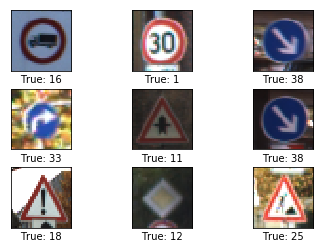

In [196]:
images = X_test[0:9]
class_true = y_test_class[0:9]

plot_images(images=images,class_true=class_true)

In [197]:
x = tf.placeholder(tf.float32,[None,img_size_flat])

In [198]:
y_true = tf.placeholder(tf.float32,[None,num_classes])

In [199]:
y_true_class = tf.placeholder(tf.int64,[None])

In [200]:
weights = tf.Variable(tf.zeros([img_size_flat,num_classes]))

In [201]:
biases = tf.Variable(tf.zeros([num_classes]))

In [202]:
logits = tf.matmul(x,weights)+biases

In [203]:
y_pred = tf.nn.softmax(logits)

In [204]:
y_pred_class = tf.argmax(y_pred,axis=1)

In [205]:
cross_entropy  = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)

In [206]:
cost = tf.reduce_mean(cross_entropy)

In [207]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [208]:
correct_prediction = tf.equal(y_pred_class,y_true_class)

In [209]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [210]:
session = tf.Session()

In [211]:
session.run(tf.global_variables_initializer())

In [212]:
batch_size = 1000

In [213]:
X_train_flattened = X_train.flatten()
X_train_f_r = X_train_flattened.reshape([39209,3072])
X_train_f_r.shape

(39209, 3072)

In [218]:
print(encoded_y_train.shape)

(39209, 43)


In [219]:
def optimize(num_iterations):
    for i in range(num_iterations):
        feed_dict_train = {x:X_train_f_r,
                       y_true: encoded_y_train}
        session.run(optimizer,feed_dict=feed_dict_train)

    

In [220]:
X_test_flattened = X_test.flatten()
X_test_f_r = X_test_flattened.reshape([12630,3072])
X_test_f_r.shape

(12630, 3072)

In [221]:
print(y_test.shape)
print(encoded_y_test.shape)

(12630,)
(12630, 43)


In [222]:
feed_dict_test = {x: X_test_f_r,
                  y_true: encoded_y_test,
                  y_true_class: y_test_class}

In [223]:
def print_accuracy():
    acc = session.run(accuracy,feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [241]:
def print_confusion_matrix():
    class_true = y_test_class
    class_pred = session.run(y_pred_class,feed_dict = feed_dict_test)
    
    cm = confusion_matrix(y_true = class_true,
                          y_pred=class_pred)
    
    print(cm)
    
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks,range(num_classes))
    plt.yticks(tick_marks,range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()
    

In [225]:
def plot_example_errors():
    correct,class_pred = session.run([correct_prediction,y_pred_class],
                                      feed_dict=feed_dict_test)
    incorrect = (correct==False)
    
    images = X_test[incorrect]
    
    class_pred = class_pred[incorrect]
    
    class_true = y_test_class[incorrect]
    
    plot_images(images= images[0:9],
               class_true=class_true[0:9],
               class_pred  = class_pred[0:9])

In [226]:
def plot_weights():
    
    w = session.run(weights)
    
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig,axes = plt.subplots(3,4)
    fig.subplots_adjust(hspace=0.3,wspace= 0.3)
    
    for i,ax in enumerate(axes.flat):
        if i<10:
            image = w[:,i].reshape(img_shape)
            
            ax.set_xlabel("Weights: {0}".format(i))
            
            ax.imshow(image,vmin = w_min,vmax = w_max,cmap = 'seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [227]:
print_accuracy()

Accuracy on test-set: 0.5%


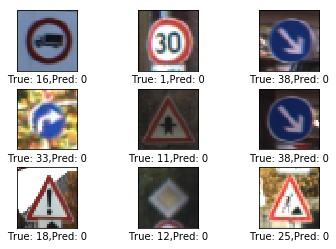

In [228]:
plot_example_errors()

In [229]:
optimize(num_iterations=1)

In [230]:
print_accuracy()

Accuracy on test-set: 5.7%


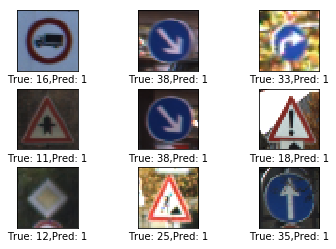

In [232]:
plot_example_errors()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

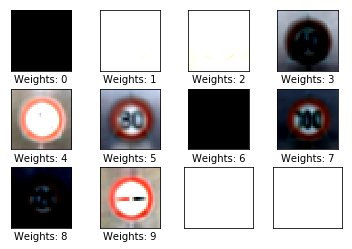

In [233]:
plot_weights()

In [248]:
optimize(num_iterations=10000)

KeyboardInterrupt: 

In [244]:
print_accuracy()

Accuracy on test-set: 74.3%


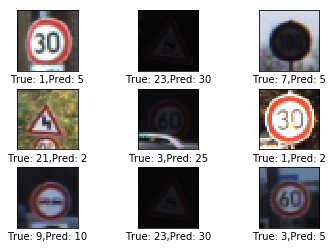

In [245]:
plot_example_errors()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

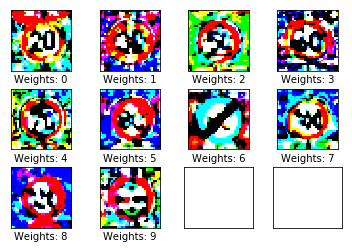

In [246]:
plot_weights()

[[ 32   0   1 ...   0   0   0]
 [ 52  83 106 ...   1   0   0]
 [ 12   0 605 ...   4   0   0]
 ...
 [  0   0   0 ...  56   0   0]
 [  0   0   0 ...   0  36   0]
 [  0   0   0 ...   0   0  69]]


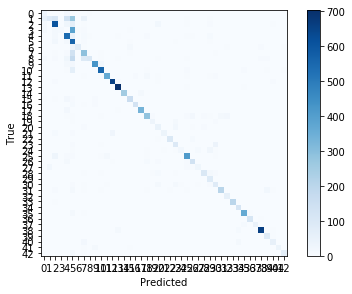

In [247]:
print_confusion_matrix()